# Car Damage Classification using SageMaker

1. [Introduction](#Introduction)
2. [Prerequisites](#Prequisites)
3. [Data Preparation](#Data-Preparation)
4. [Training](#Training)
5. [Hyperparameter Tuning](#Launch-hyperparameter-tuning-job)
6. [Inference](#Inference)
7. [Clean-up](#Clean-up)

## Introduction

Welcome to our end-to-end example of image classification using the Sagemaker 1P image classification algorithm. In this demo, we will use the Amazon sagemaker image classification algorithm in transfer learning mode to fine-tune a pre-trained model (trained on imagenet data) to learn to classify a new dataset. In particular, the pre-trained model will be fine-tuned using [Car damage dataset](https://peltarion.com/knowledge-center/tutorials/classifying-car-damage). 

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

In [1]:
%%html
<img src="lambo.jpg" width="900" height="500">

## Prequisites

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are three parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for training and model data
* The Amazon sagemaker image classification docker image which need not be changed

In [2]:

import pandas as pd
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'image_classification'

print('using bucket %s'%bucket)

arn:aws:iam::488599217855:role/AWS-Immersion-Days-Developer
using bucket sagemaker-us-east-2-488599217855


In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")
print (training_image)

825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:latest


## Data Preparation
In this notebook, we will use the car damage dataset for classification.The dataset has around 1500 images of 8 different categories.These are: 

1. Broken headlamp
2. Broken tail lamp
3. Glass shatter
4. Door scratch
5. Door dent
6. Bumper dent
7. Bumper scratch
8. Unknown

We then split this dataset into a train and holdout dataset for fine tuning the model and testing our final accuracy

 

In [5]:
num_classes = 8

In [6]:
#load index file
data = pd.read_csv('index.csv')
data.head(5)

,image,class,subset
0,image/0.jpeg,unknown,T
1,image/1.jpeg,head_lamp,T
2,image/2.jpeg,door_scratch,T
3,image/3.jpeg,head_lamp,T
4,image/4.jpeg,unknown,T


In [7]:
cats = list(data['class'].unique())
print(cats)

['unknown', 'head_lamp', 'door_scratch', 'glass_shatter', 'tail_lamp', 'bumper_dent', 'door_dent', 'bumper_scratch']


### Create Training and Validation dataset

In [8]:
train_indexes = data[data['subset']=='T']
test_indexes = data[data['subset']=='V']

In [9]:
train_indexes = train_indexes.drop(['subset'], axis=1)
test_indexes = test_indexes.drop(['subset'], axis=1)

### Calculating the number of training data

In [10]:
train_indexes.shape[0]

1275

In [11]:
!unzip -o image.zip

Archive:  image.zip
  inflating: image/1346.jpeg         
  inflating: image/666.jpeg          
  inflating: image/1203.jpeg         
  inflating: image/1080.jpeg         
  inflating: image/959.jpeg          
  inflating: image/324.jpeg          
  inflating: image/1311.jpeg         
  inflating: image/774.jpeg          
  inflating: image/1254.jpeg         
  inflating: image/261.jpeg          
  inflating: image/631.jpeg          
  inflating: image/518.jpeg          
  inflating: image/148.jpeg          
  inflating: image/298.jpeg          
  inflating: image/762.jpeg          
  inflating: image/332.jpeg          
  inflating: image/627.jpeg          
  inflating: image/277.jpeg          
  inflating: image/1242.jpeg         
  inflating: image/918.jpeg          
  inflating: image/365.jpeg          
  inflating: image/1215.jpeg         
  inflating: image/220.jpeg          
  inflating: image/559.jpeg          
  inflating: image/1096.jpeg         
  inflating: image/109.jpeg   

### Preparing dataset
The image classification algorithm can take two types of input formats. The first is a [recordio format](https://mxnet.incubator.apache.org/tutorials/basic/record_io.html) and the other is a [lst format](https://mxnet.incubator.apache.org/how_to/recordio.html?highlight=im2rec). We will use the lst file format for training.
In the .lst file we will include the serial number the class in one-hot encoding format and the filename. We will create 2 separate files for training and testing.

In [12]:
with open('train.lst', 'w') as fp:
    for ind in train_indexes.index: 
        string =''
        string += str(ind)
        string += '\t'
        class_index = cats.index(str(train_indexes['class'][ind]))
        for i in range(num_classes):
            if(class_index != i ):
                string += str(0)
            else:
                string += str(1)
            string += '\t'
        string += str(train_indexes['image'][ind]).split('/')[-1]
        
        fp.write(string)
        fp.write('\n')
    fp.close()
       
    

In [13]:
with open('test.lst', 'w') as fp:
    for ind in test_indexes.index: 
        string =''
        string += str(ind)
        string += '\t'
        class_index = cats.index(str(test_indexes['class'][ind]))
        for i in range(num_classes):
            if(class_index != i ):
                string += str(0)
            else:
                string += str(1)
            string += '\t'
        string += str(test_indexes['image'][ind]).split('/')[-1]
        
        fp.write(string)
        fp.write('\n')
    fp.close()
       

### Upload the data
Upload the data onto the s3 bucket. The images are uploaded onto train and validation bucket. The lst files are uploaded to train_lst and validation_lst folders. 

In [14]:
# Four channels: train, validation, train_lst, and validation_lst
s3train = 's3://{}/{}/train/'.format(bucket, prefix)
s3validation = 's3://{}/{}/validation/'.format(bucket, prefix)
s3train_lst = 's3://{}/{}/train_lst/'.format(bucket, prefix)
s3validation_lst = 's3://{}/{}/validation_lst/'.format(bucket, prefix)

# upload the image files to train and validation channels
!aws s3 cp image $s3train --recursive --quiet
!aws s3 cp image $s3validation --recursive --quiet

# upload the lst files to train_lst and validation_lst channels
!aws s3 cp train.lst $s3train_lst --quiet
!aws s3 cp test.lst $s3validation_lst --quiet

## Training
Now that we are done with all the setup that is needed, we are ready to train our image classifier. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.

### Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

* **Training instance count**: This is the number of instances on which to run the training. When the number of instances is greater than one, then the image classification algorithm will run in distributed settings. 
* **Training instance type**: This indicates the type of machine on which to run the training. Typically, we use GPU instances for these training 
* **Output path**: This the s3 folder in which the training output is stored

In [15]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 36000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

### Algorithm parameters

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

* **num_layers**: The number of layers (depth) for the network. We use 18 in this samples but other values such as 50, 152 can be used.
* **use_pretrained_model**: Set to 1 to use pretrained model for transfer learning.
* **image_shape**: The input image dimensions,'num_channels, height, width', for the network. It should be no larger than the actual image size. The number of channels should be same as the actual image.
* **num_classes**: This is the number of output classes for the dataset. we can set it to 8
* **mini_batch_size**: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run
* **resize**: Resize the image before using it for training. The images are resized so that the shortest side is of this parameter. 
* **epochs**: Number of training epochs
* **learning_rate**: Learning rate for training
* **num_training_samples**: This is the total number of training samples. 
* **use_weighted_loss**: This parameter is used to balance the influence of the positive and negative samples within the dataset.
* **augmentation_type**: This parameter determines the type of augmentation used for training. It can take on three values, 'crop', 'crop_color' and 'crop_color_transform'
* **precision_dtype**: The data type precision used during training. Using ``float16`` can lead to faster training with minimal drop in accuracy, paritcularly on P3 machines. By default, the parameter is set to ``float32``
* **multi_label**: Set multi_label to 0 for multi-class classification problem

You can find a detailed description of all the algorithm parameters at https://docs.aws.amazon.com/sagemaker/latest/dg/IC-Hyperparameter.html

In [16]:
model.set_hyperparameters(num_layers=18,
                             use_pretrained_model=1,
                             image_shape = "3,224,224",
                             num_classes=8,
                             mini_batch_size=128,
                             resize=256,
                             epochs=5,
                             learning_rate=0.001,
                             num_training_samples=train_indexes.shape[0],
                             use_weighted_loss=1,
                             augmentation_type = 'crop_color_transform',
                             precision_dtype='float32',
                             multi_label=0)

### Input data specification
Set the data type and channels used for training. In this training, we use application/x-image content type that require individual images and lst file for data input. In addition, Sagemaker image classification algorithm supports application/x-recordio format which can be used for larger datasets. 

In [17]:
train_data = sagemaker.session.s3_input(s3train, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3validation, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')
train_data_lst = sagemaker.session.s3_input(s3train_lst, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data_lst = sagemaker.session.s3_input(s3validation_lst, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data, 'train_lst': train_data_lst, 
                 'validation_lst': validation_data_lst}

### Start the training
Start training by calling the fit method in the estimator

In [18]:
%%time
model.fit(inputs=data_channels, logs=True)

2020-04-29 06:10:14 Starting - Starting the training job...
2020-04-29 06:10:16 Starting - Launching requested ML instances...
2020-04-29 06:11:13 Starting - Preparing the instances for training.........
2020-04-29 06:12:25 Downloading - Downloading input data...
2020-04-29 06:12:58 Training - Downloading the training image...
2020-04-29 06:13:44 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[04/29/2020 06:13:47 INFO 140354801428288] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[04/29/2020 06:13:47 INFO 140354801428288] Mer

Next, the tuning job with the following configurations need to be specified:

1. the hyperparameters that SageMaker Automatic Model Tuning will tune: learning_rate, mini_batch_size and optimizer
2. the maximum number of training jobs it will run to optimize the objective metric: 20
3. the number of parallel training jobs that will run in the tuning job: 2
4. the objective metric that Automatic Model Tuning will use: validation:accuracy

## Launch hyperparameter tuning job 
Now we can launch a hyperparameter tuning job by calling fit in tuner,setting early_stopping_type='Auto' to enable automatic training job early stopping. We will wait until the tuning finished, which may take around 2 hours .

In [19]:
import time
from time import gmtime, strftime 
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

tuning_job_name = 'image-classification-'+ str(int(time.time()*10))

hyperparameter_ranges = {'learning_rate': ContinuousParameter(0.00001, 1.0),
                         'mini_batch_size': IntegerParameter(16, 64),
                         'optimizer': CategoricalParameter(['sgd', 'adam', 'rmsprop', 'nag']),
                         'mini_batch_size': IntegerParameter(64,128)}

objective_metric_name = 'validation:accuracy'

tuner = HyperparameterTuner(model, 
                            objective_metric_name, 
                            hyperparameter_ranges,
                            objective_type='Maximize', 
                            max_jobs=6, 
                            max_parallel_jobs=3,
                            early_stopping_type='Auto')

In [ ]:
%%time
tuner.fit(inputs=data_channels, job_name=tuning_job_name, include_cls_metadata=False)
tuner.wait()

..................

After the tuning finished, the top 5 performing hyperparameters can be listed below. One can analyse the results deeper by using 

In [33]:
tuner_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
tuner_metrics.dataframe().sort_values(['FinalObjectiveValue'], ascending=False).head(5)

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,learning_rate,mini_batch_size,optimizer
4,0.933884,105.0,2020-04-29 06:19:05+00:00,image-classification-15881408974-002-90f48ebd,Completed,2020-04-29 06:17:20+00:00,0.011984,121.0,nag
0,0.916667,92.0,2020-04-29 06:23:34+00:00,image-classification-15881408974-006-904b82ba,Completed,2020-04-29 06:22:02+00:00,0.006502,116.0,nag
2,0.862500,105.0,2020-04-29 06:22:40+00:00,image-classification-15881408974-004-650eeee8,Completed,2020-04-29 06:20:55+00:00,0.000022,120.0,rmsprop
3,0.702381,91.0,2020-04-29 06:18:51+00:00,image-classification-15881408974-003-de5f66e8,Stopped,2020-04-29 06:17:20+00:00,0.003147,84.0,rmsprop
1,0.654545,99.0,2020-04-29 06:22:49+00:00,image-classification-15881408974-005-e09ee6ee,Completed,2020-04-29 06:21:10+00:00,0.007478,110.0,rmsprop


The total training time and training jobs status can be checked with the following script. 

In [34]:
total_time = tuner_metrics.dataframe()['TrainingElapsedTimeSeconds'].sum() / 3600
print("The total training time is {:.2f} hours".format(total_time))
tuner_metrics.dataframe()['TrainingJobStatus'].value_counts()

The total training time is 0.16 hours


Completed    4
Stopped      2
Name: TrainingJobStatus, dtype: int64

In [35]:
import boto3
import sagemaker
import os

region = boto3.Session().region_name
sage_client = boto3.Session().client('sagemaker')

#tuning_job_name = 'image-classification'

### Track hyperparameter tuning job progress
After you launch a tuning job, you can see its progress by calling describe_tuning_job API. The output from describe-tuning-job is a JSON object that contains information about the current state of the tuning job. You can call list_training_jobs_for_tuning_job to see a detailed list of the training jobs that the tuning job launched.

In [36]:
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

4 training jobs have completed


### Fetch all results as DataFrame
We can list hyperparameters and objective metrics of all training jobs and pick up the training job with the best objective metric.

In [37]:
import pandas as pd

tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner.dataframe()

if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        



Number of training jobs with valid objective: 6
{'lowest': 0.6514080166816711, 'highest': 0.9338840246200562}


### See TuningJob results vs time
Next we will show how the objective metric changes over time, as the tuning job progresses. For Bayesian strategy, you should expect to see a general trend towards better results, but this progress will not be steady as the algorithm needs to balance exploration of new areas of parameter space against exploitation of known good areas. This can give you a sense of whether or not the number of training jobs is sufficient for the complexity of your search space.

In [38]:
import bokeh
import bokeh.io
bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

class HoverHelper():

    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append( (k, "@{%s}" % k) )

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools='pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset'):
        return [self.hovertool(), standard_tools]

hover = HoverHelper(tuner)

p = figure(plot_width=900, plot_height=400, tools=hover.tools(), x_axis_type='datetime',y_axis_label="Objective Metric",x_axis_label="Training Start Time")
p.circle(source=df, x='TrainingStartTime', y='FinalObjectiveValue')
show(p)

Loading BokehJS ...

### Analyze the correlation between objective metric and individual hyperparameters¶
Now you have finished a tuning job, you may want to know the correlation between your objective metric and individual hyperparameters you've selected to tune. Having that insight will help you decide whether it makes sense to adjust search ranges for certain hyperparameters and start another tuning job. For example, if you see a positive trend between objective metric and a numerical hyperparameter, you probably want to set a higher tuning range for that hyperparameter in your next tuning job.

The following cell draws a graph for each hyperparameter to show its correlation with your objective metric.

In [39]:
ranges = tuner.tuning_ranges
figures = []
for hp_name, hp_range in ranges.items():
    if(hp_name == 'optimizer'):
        categorical_args = {}
        #print(hp_name)
        if hp_range.get('Values'):
            # This is marked as categorical.  Check if all options are actually numbers.
            def is_num(x):
                try:
                    float(x)
                    return 1
                except:
                    return 0           
            vals = hp_range['Values']
            if sum([is_num(x) for x in vals]) == len(vals):
                # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
                print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
            else:
                # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
                categorical_args['x_range'] = vals

        # Now plot it
        p = figure(plot_width=500, plot_height=500, 
                   title="Objective vs %s" % hp_name,
                   tools=hover.tools(),
                   x_axis_label=hp_name, y_axis_label=objective_name,
                   **categorical_args)

        p.circle(source=df, x=hp_name, y='FinalObjectiveValue')
        figures.append(p)
show(bokeh.layouts.Column(*figures))

# Inference

***

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the class of the image. You can deploy the created model by using the deploy method in the estimator

In [ ]:
%%time

ic_classifier = model.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge')

### Download test image

(460, 700, 3)


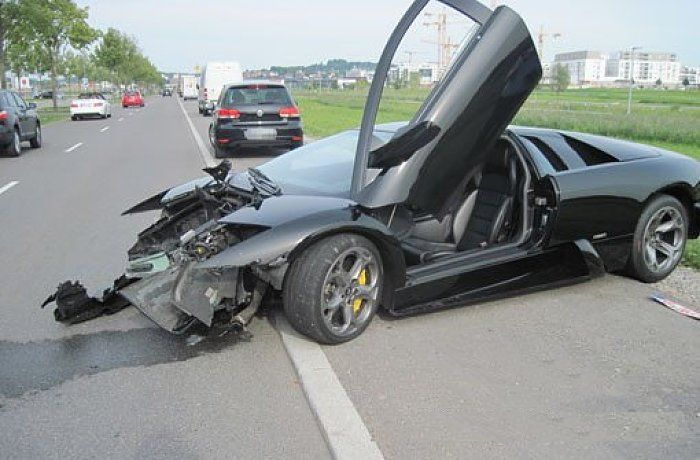

In [42]:
import cv2
file_name = 'lambo2.jpg'
im = cv2.imread(file_name)
print(im.shape)
#im = cv2.resize(im, (600, 400))
#cv2.imwrite('test.jpeg', im)

# display test image
from IPython.display import Image, display
img = Image(file_name, width=800) 
display(img)

### Evaluation

Evaluate the image through the network for inference. The network outputs class probabilities for all the classes. As can be seen from this example, the network output is pretty good even with training for only 5 epochs

In [41]:
import json

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
ic_classifier.content_type = 'application/x-image'
results = ic_classifier.predict(b)
prob = json.loads(results)

for idx, val in enumerate(cats):
    print('%s: %f '%(cats[idx],prob[idx]), end='\n')

unknown: 0.044371 
head_lamp: 0.955558 
door_scratch: 0.000003 
glass_shatter: 0.000001 
tail_lamp: 0.000014 
bumper_dent: 0.000038 
door_dent: 0.000008 
bumper_scratch: 0.000006 


## Clean up
You can use the following command to delete the endpoint. The endpoint that is created above is persistent and would consume resources till it is deleted. It is good to delete the endpoint when it is not used

In [26]:
ic_classifier.delete_endpoint()

# End!